<a href="https://colab.research.google.com/github/m-mejiap/TopicosAvanzadosEnAnalitica/blob/main/Proyecto%20Grafos/P2-AeropuertosBrasil-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aeropuertos

## Descargar las librerias y la data
La base de datos que se uso es el caso de los aeropuerto de Brasil y su conexion.

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 128.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import torch
import pandas as pd

from torch_geometric.datasets import Airports
dataset = Airports(root='.', name='Brazil')

Processing...
Done!


In [ ]:
[i for i in dataset]

[Data(x=[131, 131], edge_index=[2, 1074], y=[131])]

In [ ]:
data = dataset[0]

In [ ]:
# Print information about the dataset
print(f'Dataset: {data}')
print('-----------------------')
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
#print(f'Number of classes: {data.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Data(x=[131, 131], edge_index=[2, 1074], y=[131])
-----------------------
Number of graphs: 3
Number of features: 131

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [ ]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: BrazilAirports()
-----------------------
Number of graphs: 1
Number of nodes: 131
Number of features: 131
Number of classes: 4


In [ ]:
dataset

BrazilAirports()

Se divide manualmente la base en tres sub bases de datos. El numero maximo es el de nodos que es 131.

In [ ]:
data.train_mask = range(31,131)
data.val_mask = range(17, 30)
data.test_mask = range(16)

##Graficos

In [ ]:
#From Tensor to DataFrame
# Tensor with edge index
data.edge_index

tensor([[  0,   0,   0,  ..., 127, 129, 130],
        [  0,   1,   2,  ..., 127,   9,  84]])

In [ ]:
# From Tensor to Numpy array
data.edge_index.numpy()

array([[  0,   0,   0, ..., 127, 129, 130],
       [  0,   1,   2, ..., 127,   9,  84]])

In [ ]:
# From Tensor to DataFrame
pd.DataFrame(data.edge_index.numpy())

,0,1,2,3,4,5,6,7,8,9,...,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073
0,0,0,0,0,0,0,0,0,0,0,...,125,125,126,127,127,127,127,127,129,130
1,0,1,2,4,5,7,15,19,21,23,...,121,125,66,42,89,123,125,127,9,84


In [ ]:
# Final transformation
pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,4
4,0,5
...,...,...
1069,127,123
1070,127,125
1071,127,127
1072,129,9


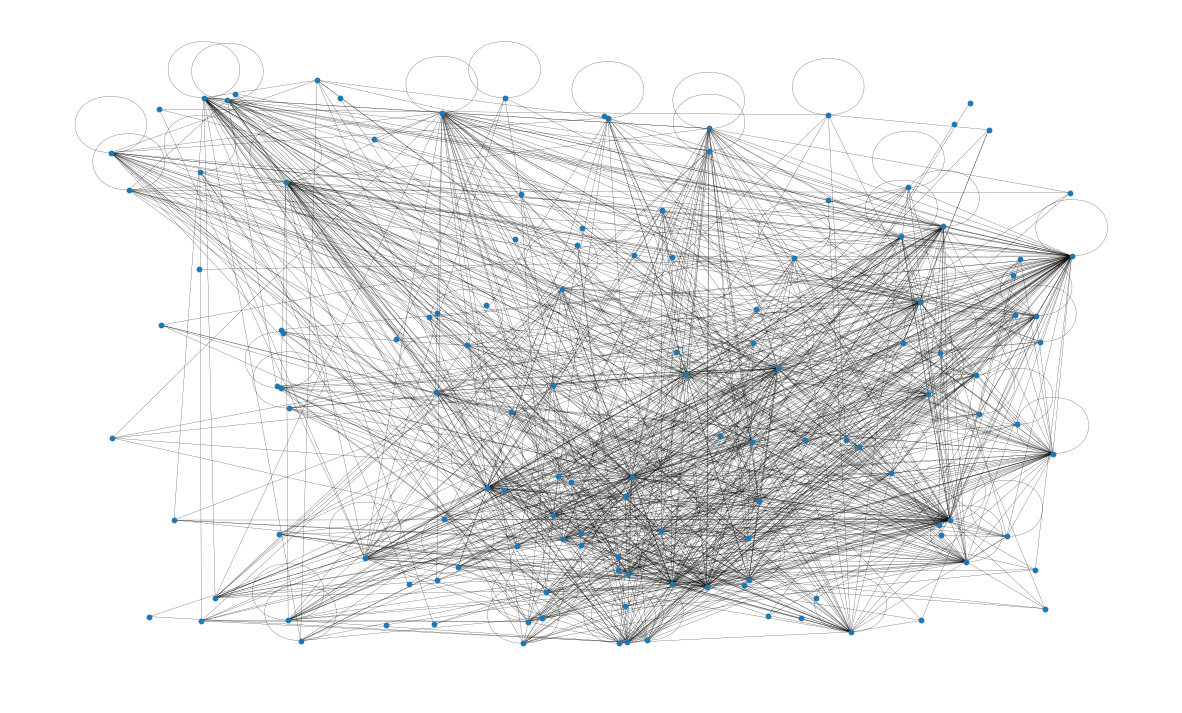

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

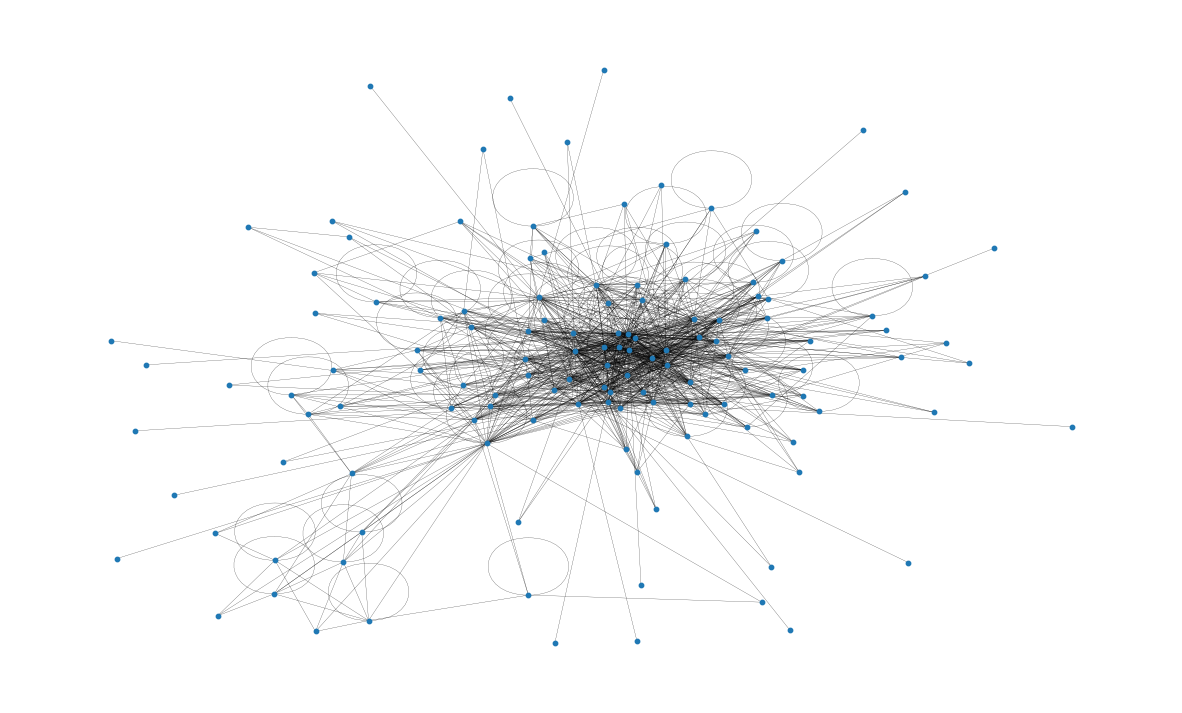

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
# Filtering at least three connections
edge_index_list_filtered = edge_index_list.groupby("start_node").filter(lambda x: len(x) > 3)
edge_index_list_filtered.head()

,start_node,end_node
0,0,0
1,0,1
2,0,2
3,0,4
4,0,5


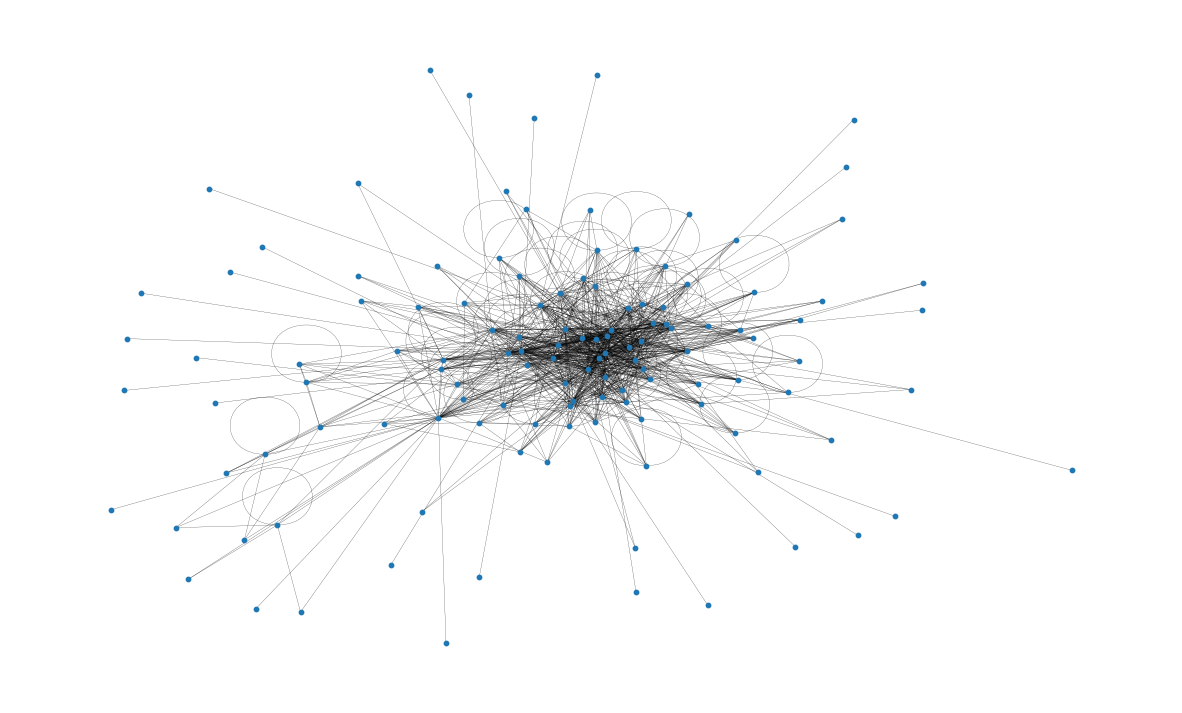

In [ ]:
G = nx.from_pandas_edgelist(edge_index_list_filtered, "start_node", "end_node")
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

##Construcción del Modelo MLP


In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F

In [ ]:
df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3


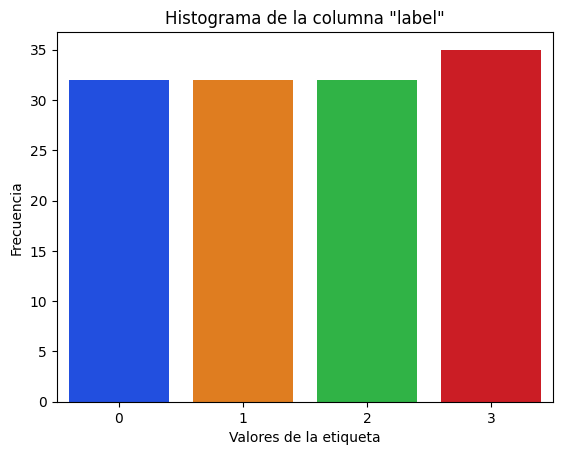

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un histograma utilizando la función countplot de Seaborn
sns.countplot(data=df_x, x='label', palette="bright")

# Agregar etiquetas y título al gráfico
plt.xlabel('Valores de la etiqueta')
plt.ylabel('Frecuencia')
plt.title('Histograma de la columna "label"')

# Mostrar el histograma
plt.show()

In [ ]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, dim_in, dim_out, num_hidden_layers, dim_h):
        super(MLP, self).__init__()

        self.layers = nn.ModuleList()

        # Capa de entrada
        self.layers.append(nn.Linear(dim_in, dim_h))

        # Capas ocultas
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(dim_h, dim_h))

        # Capa de salida
        self.layers.append(nn.Linear(dim_h, dim_out))

    def forward(self, x):
        for layer in self.layers:
            x = nn.ReLU()(layer(x))
        return nn.LogSoftmax(dim=1)(x)


    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc



In [ ]:
# Create MLP model
mlp = MLP(dim_in=dataset.num_features, dim_out=dataset.num_classes, num_hidden_layers=3, dim_h=100)
print(mlp)

# Train
mlp.fit(data, epochs=1000)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=131, out_features=100, bias=True)
    (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=4, bias=True)
  )
)
Epoch   0 | Train Loss: 1.390 | Train Acc: 15.00% | Val Loss: 1.38 | Val Acc: 38.46%
Epoch  20 | Train Loss: 0.358 | Train Acc: 85.00% | Val Loss: 10.53 | Val Acc: 15.38%
Epoch  40 | Train Loss: 0.176 | Train Acc: 100.00% | Val Loss: 5.82 | Val Acc: 15.38%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 4.82 | Val Acc: 46.15%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 2.86 | Val Acc: 15.38%
Epoch 100 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 3.01 | Val Acc: 15.38%
Epoch 120 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 3.04 | Val Acc: 15.38%
Epoch 140 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.84 | Val Acc: 15.38%
Epoch 160 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.53 | Val Acc: 15.38%
Ep

In [ ]:
# Definir parámetros de busqueda
param_grid = {
    'num_hidden_layers': [1, 2, 3, 4, 5, 6],
    'dim_h': [32, 64, 128, 256, dataset.num_features],
    'epochs': [100, 200, 300, 500]
}


In [ ]:
# Inicializar variables para realizar seguimiento del mejor resultado
best_acc = acc
best_params = {'num_hidden_layers': 4,
               'dim_h': dataset.num_features,
               'epochs': 1000}

In [ ]:
for num_layers in param_grid['num_hidden_layers']:
    for dim_h in param_grid['dim_h']:
        for num_epochs in param_grid['epochs']:
            # Crear un nuevo modelo MLP num_layers y dim_h
            mlp = MLP(dim_in=dataset.num_features, dim_out=dataset.num_classes, num_hidden_layers=num_layers, dim_h=dim_h)

            # Entrena el modelo con las epocas num_epochs
            mlp.fit(data, epochs=num_epochs)

            # Evaluar el modelo
            acc = mlp.test(data)

            # Comprueba si esta combinación de hiperparámetros es la mejor hasta ahora
            if acc > best_acc:
                best_acc = acc
                best_params = {
                    'num_hidden_layers': num_layers,
                    'dim_h': dim_h,
                    'epochs': num_epochs
                }

Epoch   0 | Train Loss: 1.384 | Train Acc: 31.00% | Val Loss: 1.40 | Val Acc: 0.00%
Epoch  20 | Train Loss: 1.033 | Train Acc: 60.00% | Val Loss: 1.90 | Val Acc: 0.00%
Epoch  40 | Train Loss: 0.570 | Train Acc: 73.00% | Val Loss: 1.59 | Val Acc: 0.00%
Epoch  60 | Train Loss: 0.556 | Train Acc: 75.00% | Val Loss: 1.39 | Val Acc: 38.46%
Epoch  80 | Train Loss: 0.556 | Train Acc: 75.00% | Val Loss: 1.39 | Val Acc: 38.46%
Epoch 100 | Train Loss: 0.557 | Train Acc: 75.00% | Val Loss: 1.39 | Val Acc: 38.46%
Epoch   0 | Train Loss: 1.387 | Train Acc: 25.00% | Val Loss: 1.37 | Val Acc: 46.15%
Epoch  20 | Train Loss: 1.043 | Train Acc: 56.00% | Val Loss: 1.34 | Val Acc: 46.15%
Epoch  40 | Train Loss: 0.649 | Train Acc: 56.00% | Val Loss: 1.43 | Val Acc: 46.15%
Epoch  60 | Train Loss: 0.611 | Train Acc: 71.00% | Val Loss: 1.48 | Val Acc: 0.00%
Epoch  80 | Train Loss: 0.611 | Train Acc: 71.00% | Val Loss: 1.38 | Val Acc: 46.15%
Epoch 100 | Train Loss: 0.612 | Train Acc: 71.00% | Val Loss: 1.39 | 

In [ ]:
# Imprimir los mejores hiperparámetros y la mejor precisión
print(f'Best Hyperparameters: {best_params}')
print(f'Best Accuracy: {best_acc*100:.2f}%')

Best Hyperparameters: {'num_hidden_layers': 1, 'dim_h': 32, 'epochs': 100}
Best Accuracy: 68.75%
